In [1]:
%matplotlib inline

import re
import time
import datetime
from collections import defaultdict
import itertools

import nltk

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import *
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import seaborn as sns; sns.set()

import statsmodels.api as sm

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

THEANO_FLAGS='cxx=""'

print 'theano device: %s' % theano.config.device   # we're using CPUs
print 'theano floatX: %s' % theano.config.floatX   # should be 64 bit for CPUs

/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Home/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Home/envs/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in

Couldn't import dot_parser, loading of dot files will not be possible.
theano device: cpu
theano floatX: float64


In [2]:
global start_time
global function_start_time
global classifierInfo_list
global y_pred_rf

start_time = time.time()
function_start_time = time.time()

'''
Objects
'''
# object for encapsulating classifier and related data
class classifierInfo(object):
    def __init__(self, classifier, accuracy_score):
        self.classifier = classifier
        self.classifier_name = classifier.__class__.__name__
        self.accuracy_score = accuracy_score
        self.note = ''
    def __str__(self):
        return 'classifierInfo name: "%s", accuracy_score: %f' % (self.classifier_name, self.accuracy_score)

'''
Utility functions
'''
def printElapsedTime(note):
    secs = time.time()-function_start_time
    mins = np.int(secs/60)
    secs = secs % 60.0
    print_string = '\nElapsed time ({}): {:d}:{:06.3f}'.format( note, mins, secs)
    secs = time.time()-start_time
    mins = np.int(secs/60)
    secs = secs % 60.0
    print_string += '\nTotal elapsed time: {:d}:{:06.3f}'.format( mins, secs)
    print print_string


def printElapsedTimeReport(function_name):
    secs = time.time()-start_time
    mins = np.int(secs/60)
    secs = secs % 60.0
    formatted_time = '{:d}:{:06.3f}'.format( mins, secs)
    print '{:<35}{:>10}'.format(function_name, formatted_time)

# print the list of coolumns in a dataframe
def printDataframeColumns(df):
    cols = df.columns.values.tolist()
    print "\ncol name\n--- --------------------------------------------"
    for i in range(len(cols)):
        print '%3d \"%s\"' % ( i, cols[i] )
        
# method to print topics
def print_topics(topics, feature_names, sorting, topics_per_chunk=5, n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for j in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(*feature_names[sorting[these_topics, j]]))
            except:
                pass
        print("\n")

# fucntion to report the contents of the classifierInfo_list list
def classifierReport(title):
    sorted_classifierInfo_list = sorted(classifierInfo_list, key=lambda x: x.accuracy_score, reverse=True)
    
    print title
    print '-'*48
    for i, clfInfo in enumerate(sorted_classifierInfo_list):
        formatted_name = clfInfo.classifier_name + ' accuracy:'
        formatted_score = '{:06.3f}'.format( clfInfo.accuracy_score)
        print '{:<37} {:>6}%'.format( formatted_name, formatted_score )
        if clfInfo.note != '':
            print '--  {:s}'.format(clfInfo.note)


In [3]:
# ensembling with pre-fitted classifiers in classifierInfo_list  
def ensembling_1(x_train, y_train, x_test, y_test, title):
    # Create zero-filled arrays for train and test blend data
    listLen = len(classifierInfo_list)
    sorted_classifierInfo_list = sorted(classifierInfo_list, key=lambda x: x.accuracy_score, reverse=True)
    
    x_train_blend = np.zeros((x_train.shape[0], listLen))
    x_test_blend = np.zeros((x_test.shape[0], listLen))

    print '\n\nEnsembling With Pre-Fitted Classifiers\n%s' % ('-'*45 )
    print 'x_train_blend: %s' % str(x_train_blend.shape)
    print 'x_test_blend: %s\n' % str(x_test_blend.shape)

    # enumerate the list of classifierInfo objects
    for i, clfInfo in enumerate(sorted_classifierInfo_list):
        # extract the trained classifier
        clf = clfInfo.classifier

        y_train_data = clf.predict_proba(x_train)[:,1]
        x_train_blend[:,i] = y_train_data

        y_test_data = clf.predict_proba(x_test)[:,1]
        x_test_blend[:,i] = y_test_data
        print i, clf.__class__.__name__

        if i == listLen-1: break

    x_train_blend = np.concatenate(( x_train, x_train_blend ), axis=1)
    x_test_blend = np.concatenate(( x_test, x_test_blend ), axis=1)

    print '\nx_train_blend: %s' % str(x_train_blend.shape)
    print 'x_test_blend: %s\n' % str(x_test_blend.shape)

    clf = LogisticRegression(C=0.01)
    clf.fit(x_train_blend, y_train)

    accuracy = clf.score(x_test_blend, y_test)*100.0
    print title
    print '-'*48
    print 'Accuracy: %f%%' % accuracy
    
# ensembling from scratch with a list of unfitted classifiers
def ensembling_2(x_train, y_train, x_test, y_test, title):
    base_models = [
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)
    ]
    
    n_folds = 5
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    folds = list(KFold(len(y_train), n_folds=n_folds, shuffle=True, random_state=2016))

    print '\n\nEnsembling With Non-Fitted Classifiers\n%s' % ('-'*45 )
    
    x_train_blend = np.zeros((x_train.shape[0], len(base_models)))
    x_test_blend = np.zeros((x_test.shape[0], len(base_models)))

    print 'x_train_blend: %s' % str(x_train_blend.shape)
    print 'x_test_blend: %s\n' % str(x_test_blend.shape)
    
    for i, clf in enumerate(base_models):
        print i, clf.__class__.__name__
        x_test_blend_i = np.zeros((x_test.shape[0], len(folds)))
        for j, (train_idx, test_idx) in enumerate(folds):
            X_train = x_train[train_idx]
            Y_train = y_train[train_idx]
            X_holdout = x_train[test_idx]
            clf.fit(X_train, Y_train)
            y_pred = clf.predict(X_holdout)[:]
            x_train_blend[test_idx, i] = y_pred
            x_test_blend_i[:, j] = clf.predict(x_test)[:]
        x_test_blend[:, i] = x_test_blend_i.mean(1)

    print x_test.shape, x_test_blend.shape
    
    x_train_blend = np.concatenate(( x_train, x_train_blend ), axis = 1)
    x_test_blend = np.concatenate(( x_test, x_test_blend ), axis = 1)
        
    print '\nx_train_blend: %s' % str(x_train_blend.shape)
    print 'x_test_blend: %s\n' % str(x_test_blend.shape)
    
    stack_clf = LogisticRegression()
    stack_clf.fit(x_train_blend, y_train)

    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0

    #accuracy = clf.score(x_test_blend, y_test)*100.0
    
    print title
    print '-'*48
    print 'Accuracy: %f%%' % accuracy
    

In [4]:
# immature CNN attempt
def cnnProcess(x_train, y_train, x_test, y_test):
    def binarizeY(labels):
        binarized_labels = np.zeros((labels.size, 2))
        for i in range(labels.size):
            binarized_labels[i,labels[i]] = 1
        return binarized_labels
    
    def gradientDescent(epochs):
        score = 0.0
        for i in range(epochs):
            cost = train(x_train[0:len(x_train)], y_train_b[0:len(x_train)])
            accuracy = np.mean(np.argmax(y_test_b, axis=1) == predict(x_test))
            if accuracy > score: score = accuracy*100.0
            print '%d) accuracy = %.4f%%' %(i+1, score)
        return score
        
    #(1) Parameters
    numFeatures = x_train.shape[1]
    numClasses = len(np.unique(y_test))
    
    y_test_b = binarizeY(y_test)
    y_train_b = binarizeY(y_train)
    
    # initialize the weights to small values (non-zero)
    w = theano.shared(np.asarray((np.random.randn(*(numFeatures, numClasses))*.01)))

    X = T.matrix()
    Y = T.matrix()

    #(2) Model
    y_hat = T.nnet.softmax(T.dot(X, w))
    
    #(3) Cost Function
    cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))
    
    #(4) Execute
    alpha = 0.000001
    gradient = T.grad(cost=cost, wrt=w) 
    update = [[w, w - gradient * alpha]] 
    train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True) # computes cost, then runs update
    y_pred = T.argmax(y_hat, axis=1) # select largest probability as prediction
    predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

    score = gradientDescent(5)
    predict(x_test) 

In [5]:
RAOP = pd.read_json('pizza_request_dataset.json')
printDataframeColumns(RAOP)
RAOP.head(n=10)


col name
--- --------------------------------------------
  0 "giver_username_if_known"
  1 "in_test_set"
  2 "number_of_downvotes_of_request_at_retrieval"
  3 "number_of_upvotes_of_request_at_retrieval"
  4 "post_was_edited"
  5 "request_id"
  6 "request_number_of_comments_at_retrieval"
  7 "request_text"
  8 "request_text_edit_aware"
  9 "request_title"
 10 "requester_account_age_in_days_at_request"
 11 "requester_account_age_in_days_at_retrieval"
 12 "requester_days_since_first_post_on_raop_at_request"
 13 "requester_days_since_first_post_on_raop_at_retrieval"
 14 "requester_number_of_comments_at_request"
 15 "requester_number_of_comments_at_retrieval"
 16 "requester_number_of_comments_in_raop_at_request"
 17 "requester_number_of_comments_in_raop_at_retrieval"
 18 "requester_number_of_posts_at_request"
 19 "requester_number_of_posts_at_retrieval"
 20 "requester_number_of_posts_on_raop_at_request"
 21 "requester_number_of_posts_on_raop_at_retrieval"
 22 "requester_number_of_subreddi

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,False,2,6,0,t3_w5491,7,"I'm not in College, or a starving artist or an...","I'm not in College, or a starving artist or an...","[Request] Ontario, Canada - On my 3rd of 5 day...",...,True,"[AdviceAnimals, WTF, funny, gaming, movies, te...",32,212,48,610,shroom,RitalinYourMemory,1341604684,1341601084
1,N/A,False,2,6,1,t3_qysgy,8,Hello! It's been a hard 2 months with money an...,Hello! It's been a hard 2 months with money an...,"[REQUEST] Southern Arizona, Tucson Hungry Family",...,True,"[aww, pics]",5,21,13,57,shroom,blubirdhvn,1331868375,1331864775
2,N/A,False,1,4,1,t3_if0ed,1,I'm sure there are needier people on this subr...,I'm sure there are needier people on this subr...,[Request] Pizza for a broke college student,...,True,"[AskReddit, DoesAnybodyElse, IAmA, Marijuana, ...",1359,2110,2423,3456,shroom,taterpot,1309622289,1309618689
3,N/A,False,2,13,0,t3_jr3w1,3,I've been unemployed going on three months now...,I've been unemployed going on three months now...,[Request] Unemployed and Sick of Rice (Suffolk...,...,True,"[AdviceAnimals, Art, AskReddit, BookCollecting...",1205,4889,2403,8245,shroom,or_me_bender,1314060079,1314056479
4,N/A,False,1,4,1366847814,t3_1d18tc,5,I ran out of money on my meal card a while bac...,I ran out of money on my meal card a while bac...,"[Request] Ohio USA, broke student musician in ...",...,True,"[TrueAtheism, atheism, funny]",81,86,225,232,shroom,m_chamberlin,1366839643,1366836043
5,N/A,False,5,34,0,t3_198a81,18,,,"[Request] [Manteca, CA] 17 days sober and kind...",...,True,"[GameDeals, IndieGameBundles, IndieGaming, Ran...",51,108,89,180,shroom,cheesepile,1361842335,1361842335
6,thisfreaknguy,False,1,2,1364351254,t3_1b33f3,1,Hi amazing people! I've known of this subreddi...,Hi amazing people! I've known of this subreddi...,"[request] Camden, SC USA - Broke until Thursda...",...,True,"[AdviceAnimals, AskReddit, Frugal, LadyBoners,...",87,648,133,916,shroom,yall_weird,1364354549,1364350949
7,N/A,False,2,8,0,t3_toxi0,5,I have a couple babysitting gigs lined up next...,I have a couple babysitting gigs lined up next...,"[request] college student, just started first ...",...,True,"[AdviceAnimals, AppHookup, AskReddit, Australi...",145,3220,277,5798,shroom,STHOA,1337123667,1337120067
8,N/A,False,6,12,0,t3_12s9wy,2,,,[request] Had to put my dog down today. broke ...,...,True,"[AskReddit, Documentaries, FanTheories, Foreve...",2385,5407,3671,14317,shroom,Emmaleep,1352271364,1352271364
9,N/A,False,3,6,1,t3_tc5sp,3,So it's finals week and I haven't eaten all da...,So it's finals week and I haven't eaten all da...,[Request] College Student would love a pizza...,...,True,"[AskReddit, DessertPorn, IAmA, LongDistance, Q...",167,482,263,768,shroom,shmily16,1336443909,1336440309


# Data Exploration

In [6]:
print RAOP.shape

(5671, 33)


In [7]:
print RAOP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5671 entries, 0 to 5670
Data columns (total 33 columns):
giver_username_if_known                                 5671 non-null object
in_test_set                                             5671 non-null bool
number_of_downvotes_of_request_at_retrieval             5671 non-null int64
number_of_upvotes_of_request_at_retrieval               5671 non-null int64
post_was_edited                                         5671 non-null int64
request_id                                              5671 non-null object
request_number_of_comments_at_retrieval                 5671 non-null int64
request_text                                            5671 non-null object
request_text_edit_aware                                 5671 non-null object
request_title                                           5671 non-null object
requester_account_age_in_days_at_request                5671 non-null float64
requester_account_age_in_days_at_retrieval         

In [8]:
#print(RAOP.describe())

In [9]:
print RAOP["requester_received_pizza"].value_counts()

False    4274
True     1397
Name: requester_received_pizza, dtype: int64


In [10]:
# Make a copy of source data for cleanup and feature engineering
RAOP_updated = RAOP.copy()

# Feature Engineering

In [11]:
def text_preprocessor(s):
    s =  re.compile("[^\w']|_").sub(" ",s.lower())
    # remove mutiple spaces
    s= re.sub(' +',' ', s)
    return s    

In [12]:
# set timer
start_time = time.time()
print "Start of Feature Engineering"

### New columns: 
#request_text_updated : remove special characters from request text (edit aware) and make it lower case
#request_title_updated: remove special characters from title text and make it lower case
#request_title_plus_text: concatenate request and title text after the update. 
#request_text_length: get length of request text 
#request_title_text_length: get length of combined request and title text

RAOP_updated["request_text_updated"] = RAOP_updated.apply(lambda updated_text: text_preprocessor(updated_text["request_text_edit_aware"]), axis=1)
RAOP_updated["request_title_updated"] = RAOP_updated.apply(lambda updated_text: text_preprocessor(updated_text["request_title"]), axis=1)

# Add a new column containing text from both the request and title
RAOP_updated["request_title_plus_text"] =  RAOP_updated["request_title_updated"] + ' ' + RAOP_updated["request_text_updated"]

# Add a new column for length of request and combined (request plus title) text
RAOP_updated["request_text_length"] = RAOP_updated.apply(lambda text_length: len(text_length["request_text_updated"]), axis=1)
RAOP_updated["request_title_text_length"] = RAOP_updated.apply(lambda text_length: len(text_length["request_title_plus_text"]), axis=1)

#RAOP_updated.head()

Start of Feature Engineering


In [13]:
#New column:
#image_in_text: check presence of certain words such as 'imgur.com|.jpg|.png|.jpeg' which indicates presence of images 
#used to provide evidence of need. Use it to make binary column with True(1) for presence of image and False(0) for not.
image_in_text = RAOP_updated["request_title_plus_text"].str.contains('imgur.com|.jpg|.png|.jpeg', case=False)
image_in_text.name = "image_in_text"
RAOP_updated = pd.concat([RAOP_updated, pd.DataFrame(image_in_text)], axis='col') 
RAOP_updated["image_in_text"].value_counts()

False    5423
True      248
Name: image_in_text, dtype: int64

In [14]:
# Removed Per Kaggle instruction.
#Update column requester_user_flair to have binary values : 1 if it contains either shroom or PIF and 0 if it doesn't.
#RAOP_updated["requester_user_flair"].value_counts()
#RAOP_updated.loc[((RAOP_updated.requester_user_flair!= 'shroom') & (RAOP_updated.requester_user_flair != 'PIF')), 'requester_user_flair'] = 0
#RAOP_updated.loc[((RAOP_updated.requester_user_flair== 'shroom') | (RAOP_updated.requester_user_flair == 'PIF')), 'requester_user_flair'] = 1 
#RAOP_updated.loc[RAOP_updated.requester_user_flair== 0]
#RAOP_updated["requester_user_flair"].value_counts()

In [15]:
# New column
#spelling_errors_ratio: ratio of spelling errors in text and title to the length of total text plus title
function_start_time=time.time()
from enchant.checker import SpellChecker
chkr = SpellChecker("en_US")
d = {}
l=[]
for i in range(RAOP_updated.shape[0]):
    request_title_text = RAOP_updated["request_title_plus_text"][i]
    request_title_text_length = int(RAOP_updated["request_title_text_length"][i])
    chkr.set_text(request_title_text)
    count=0
    fraction_spelling_error=0
    for err in chkr:
        count+=1
    fraction_spelling_error =  (count *1.0) /request_title_text_length
    l.append(fraction_spelling_error)
d.update({'spelling_errors_ratio':l})
RAOP_updated = pd.concat([RAOP_updated, pd.DataFrame(d)], axis='col')
#RAOP_updated["spelling_errors"].value_counts()
#RAOP_updated["spelling_errors_ratio"][0:100]

printElapsedTime('SpellCheck')


Elapsed time (SpellCheck): 0:35.612
Total elapsed time: 0:37.256


In [16]:
# New column
# part_of_month_indicator: binary values: 0 if first half of month and 1 if it's second half of month.
d = {}
l=[]
for i in range(RAOP_updated.shape[0]):
    request_time_utc = datetime.datetime.utcfromtimestamp(RAOP_updated["unix_timestamp_of_request_utc"][i])
    request_time_utc_day = request_time_utc.day
    part_of_month = 2
    if int(request_time_utc_day) < 16:
        part_of_month = 0  
    else:
        part_of_month = 1
    l.append(part_of_month)
d.update({'part_of_month_indicator':l})
  
print len(l)
#nouns_df = pd.DataFrame(nouns_df)   
RAOP_updated = pd.concat([RAOP_updated, pd.DataFrame(d)], axis='col')
RAOP_updated["part_of_month_indicator"].value_counts()

5671


1    2982
0    2689
Name: part_of_month_indicator, dtype: int64

In [17]:
#Update column:
#giver_username_if_known: binary values: 1 if giver username is known and 0 if it is not.
RAOP_updated.loc[(RAOP_updated.giver_username_if_known!= 'N/A'),  'giver_username_if_known'] = 1
RAOP_updated.loc[(RAOP_updated.giver_username_if_known== 'N/A'),  'giver_username_if_known'] = 0
#print RAOP_updated.loc[(RAOP_updated.giver_username_if_known!= 'N/A')].shape
RAOP_updated.giver_username_if_known.value_counts()

0    5271
1     400
Name: giver_username_if_known, dtype: int64

In [18]:
# Change data type from boolean to int (0, 1)
RAOP_updated.requester_received_pizza = RAOP_updated.requester_received_pizza.astype(int)
RAOP_updated.image_in_text = RAOP_updated.image_in_text.astype(int)
#RAOP_updated.requester_user_flair = RAOP_updated.requester_user_flair.astype(int)
RAOP_updated.giver_username_if_known = RAOP_updated.giver_username_if_known.astype(int)
RAOP_updated.part_of_month_indicator = RAOP_updated.part_of_month_indicator.astype(int)

In [19]:
print RAOP_updated.info() 
#print RAOP_updated.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5671 entries, 0 to 5670
Data columns (total 41 columns):
giver_username_if_known                                 5671 non-null int64
in_test_set                                             5671 non-null bool
number_of_downvotes_of_request_at_retrieval             5671 non-null int64
number_of_upvotes_of_request_at_retrieval               5671 non-null int64
post_was_edited                                         5671 non-null int64
request_id                                              5671 non-null object
request_number_of_comments_at_retrieval                 5671 non-null int64
request_text                                            5671 non-null object
request_text_edit_aware                                 5671 non-null object
request_title                                           5671 non-null object
requester_account_age_in_days_at_request                5671 non-null float64
requester_account_age_in_days_at_retrieval          

# Topic Modelling Using Unsupervised Method

In [20]:
function_start_time=time.time()
# Get text for all the requests for combined request and title.
request_text_with_title=''
for i in range(RAOP_updated.shape[0]):
    request_text_with_title+= str(RAOP_updated["request_title_plus_text"][i])

#Get nouns for all the request texts plus title
text = request_text_with_title
text=text.lower()
token_text= nltk.word_tokenize(text)
tagged_sent = nltk.pos_tag(token_text)
nouns= []
noun_array = np.chararray((RAOP_updated.shape[0], 10000))
adjectives= []
adjectives_array = np.chararray((RAOP_updated.shape[0], 10000))
verbs= []
verbs_array = np.chararray((RAOP_updated.shape[0], 10000))
for word,pos in tagged_sent:
    if pos in ['NN',"NNP","NNS", "NNPS"]:
        nouns.append(word)
    elif pos in ['JJ',"JJR","JJS"]:
        adjectives.append(word)
    elif pos in ['VB',"VBD","VBG",'VBN',"VBP","VBZ"]:
        verbs.append(word)
freq_nouns=nltk.FreqDist(nouns)
top_100_noun =[x[0] for x in freq_nouns.most_common(100)[:]]
top_200_noun =[x[0] for x in freq_nouns.most_common(200)[:]]
top_250_noun =[x[0] for x in freq_nouns.most_common(250)[:]]


freq_adjectives=nltk.FreqDist(adjectives)
top_100_adjectives =[x[0] for x in freq_adjectives.most_common(100)[:]]
top_250_adjectives =[x[0] for x in freq_adjectives.most_common(250)[:]]

freq_verbs=nltk.FreqDist(verbs)
top_100_verbs =[x[0] for x in freq_verbs.most_common(100)[:]]
top_250_verbs =[x[0] for x in freq_verbs.most_common(250)[:]]

#top_500_words = top_250_noun + top_250_adjectives + top_250_verbs
top_words_nouns_adjectives = top_250_noun + top_250_adjectives
top_words_nouns_adjectives = list(set(top_words_nouns_adjectives))

printElapsedTime("top 100, 200 nouns processed")


Elapsed time (top 100, 200 nouns processed): 0:51.675
Total elapsed time: 1:29.279


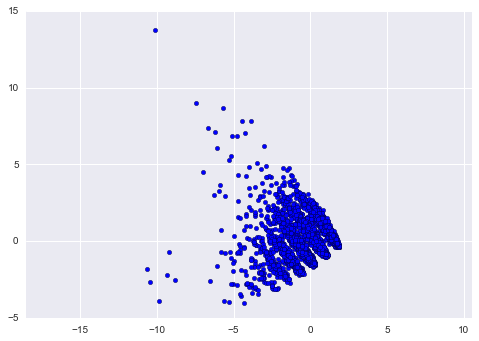

In [21]:
# See the topic clusters based on the top 200 nouns.
# Using PCA reduce the features to 2 dimension and plot to see how the topics are clustered.
# Looks like there are five clusters for the top 200 nouns
vectorizer = CountVectorizer(min_df=1, vocabulary=top_words_nouns_adjectives)
X_train_data = vectorizer.fit_transform(RAOP_updated["request_title_plus_text"])
X_train_data.shape

pca = PCA(n_components =2)
pca.fit(X_train_data.toarray())
X_pca= pca.transform(X_train_data.toarray())
#print X_pca.shape
#X_pca[0:100,:]

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.axis('equal');

In [22]:
# Using LDA (Latent Dirichlet Allocation), perform topic modelling for top 250 nouns  and adjectives
function_start_time=time.time()

vectorizer = CountVectorizer(min_df=1, vocabulary=top_words_nouns_adjectives)
X_train_data = vectorizer.fit_transform(RAOP_updated["request_title_plus_text"])
print X_train_data.shape

lda = LatentDirichletAllocation(n_topics=5, learning_method="batch", max_iter=25, random_state=0)
document_topics = lda.fit_transform(X_train_data)
print lda.components_.shape

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names())
# Print out the 5 topics:

num_topics = 5
num_words=len(top_words_nouns_adjectives)/num_topics
print_topics(topics=range(5), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=num_words)

topwords = defaultdict(list)
temp = []

topics =  range(num_topics)
for i in range(num_topics): 
    topwords[topics[i]].append(list(feature_names[sorting[i, 0:num_words]]))

printElapsedTime("LDA topic modeling")

(5671, 470)
(5, 470)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
pizza         pizza         pizza         pizza         request       
request       com           request       request       get           
love          http          help          time          food          
hungry        request       family        job           week          
college       imgur         food          get           pay           
broke         reddit        tonight       work          money         
student       card          kids          one           help          
thanks        gift          dinner        day           last          
get           jpg           birthday      more          next          
day           picture       get           long          pizza         
tonight       www           money         help          job           
help          amp           house         food          

In [23]:
#Get frequency of top nouns for each row for each topic and add them to the data frame: RAOP_updated.
function_start_time=time.time()

num_topics = 5
count_df= []
topics = ['topic1','topic2','topic3','topic4','topic5']

for i in range(RAOP_updated.shape[0]):
    d = {}
    for j in range(num_topics):
        count = 0
        for words in topwords[j]:  
            word_regexs = words
        request = pd.Series(RAOP_updated["request_title_plus_text"][i])
        count= sum(pd.Series((pd.Series(request).str.contains(r).sum() for r in word_regexs), word_regexs, name='count'))
        d.update({topics[j]:count})
    count_df.append(d)
RAOP_updated = pd.concat([RAOP_updated, pd.DataFrame(count_df)], axis='col')
RAOP_updated_all = RAOP_updated
#print RAOP_updated.head()  
printElapsedTime("top nouns frequency")


Elapsed time (top nouns frequency): 15:53.328
Total elapsed time: 18:46.672


In [24]:
RAOP_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5671 entries, 0 to 5670
Data columns (total 46 columns):
giver_username_if_known                                 5671 non-null int64
in_test_set                                             5671 non-null bool
number_of_downvotes_of_request_at_retrieval             5671 non-null int64
number_of_upvotes_of_request_at_retrieval               5671 non-null int64
post_was_edited                                         5671 non-null int64
request_id                                              5671 non-null object
request_number_of_comments_at_retrieval                 5671 non-null int64
request_text                                            5671 non-null object
request_text_edit_aware                                 5671 non-null object
request_title                                           5671 non-null object
requester_account_age_in_days_at_request                5671 non-null float64
requester_account_age_in_days_at_retrieval          

# Topic Modelling per Stanford paper

In [25]:
# Narratives per Standford paper
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "Friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]

In [26]:
# Similar to the earlier approach, Get frequency of these top nouns for each row for each narrative and create a new data frame "narratives"with them  
function_start_time=time.time()

num_topics = 5
count_df= []
topics = ['money','job','student','family','craving']
for i in range(RAOP_updated.shape[0]):
    d = {}
    for j in range(num_topics):
        count = 0
        #print narratives[j]
        request = pd.Series(RAOP_updated["request_title_plus_text"][i])
        count= sum(pd.Series((pd.Series(request).str.contains(r).sum() for r in narratives[j]), narratives[j], name='count'))
        d.update({topics[j]:count})
    count_df.append(d)
narratives = pd.DataFrame(count_df)

printElapsedTime("top nouns frequency, Stanford narratives")


Elapsed time (top nouns frequency, Stanford narratives): 4:02.236
Total elapsed time: 22:49.352


In [27]:
narratives.head()

,craving,family,job,money,student
0,0,0,2,10,1
1,0,2,0,7,0
2,0,0,0,8,2
3,2,0,1,3,1
4,0,1,0,7,1


# Data Cleanup

In [28]:
print "Start of Data Cleanup"
# Drop columns: 
#'request_id'
#'requester_username'
#'requester_subreddits_at_request'
#'requester_user_flair': Per Kaggle instructions
#'in_test_set', 
#'request_text', 
#'request_text_edit_aware',
#'request_title', 
#'request_text_updated', '
#request_text_updated', 
#'request_title_updated', 
#'request_title_plus_text', 
#'request_text_length'
#'unix_timestamp_of_request', 
#'unix_timestamp_of_request_utc'

drop_columns = ['request_id', 'requester_username', 'requester_subreddits_at_request', 'requester_user_flair',
                'in_test_set','request_text', 'request_text_edit_aware', 'request_title', 'request_text_updated',
                'request_title_updated', 'request_title_plus_text', 'request_text_length', 'unix_timestamp_of_request',
                'unix_timestamp_of_request_utc']
RAOP_updated = RAOP_updated.drop(drop_columns, 1)


Start of Data Cleanup


In [29]:
# Create a new data frame : RAOP_updated_stanford by dropping topics from RAOP_updated and then adding data frame narratives
# Drop columns:  
#'unix_timestamp_of_request', 
#'unix_timestamp_of_request_utc'

#RAOP_updated_stanford = RAOP_updated.drop(['topic1', 'topic2', 'topic3', 'topic4', 'topic5'], 1) 

In [30]:
# Append data frame- narratives 
#RAOP_updated_stanford = pd.concat([RAOP_updated_stanford, narratives], axis='col')
RAOP_updated_stanford = pd.concat([RAOP_updated, narratives], axis='col')

In [31]:
# Print columns in data frame: RAOP_updated_all
printDataframeColumns(RAOP_updated_all)


col name
--- --------------------------------------------
  0 "giver_username_if_known"
  1 "in_test_set"
  2 "number_of_downvotes_of_request_at_retrieval"
  3 "number_of_upvotes_of_request_at_retrieval"
  4 "post_was_edited"
  5 "request_id"
  6 "request_number_of_comments_at_retrieval"
  7 "request_text"
  8 "request_text_edit_aware"
  9 "request_title"
 10 "requester_account_age_in_days_at_request"
 11 "requester_account_age_in_days_at_retrieval"
 12 "requester_days_since_first_post_on_raop_at_request"
 13 "requester_days_since_first_post_on_raop_at_retrieval"
 14 "requester_number_of_comments_at_request"
 15 "requester_number_of_comments_at_retrieval"
 16 "requester_number_of_comments_in_raop_at_request"
 17 "requester_number_of_comments_in_raop_at_retrieval"
 18 "requester_number_of_posts_at_request"
 19 "requester_number_of_posts_at_retrieval"
 20 "requester_number_of_posts_on_raop_at_request"
 21 "requester_number_of_posts_on_raop_at_retrieval"
 22 "requester_number_of_subreddi

In [32]:
# Print columns in data frame: RAOP_updated
printDataframeColumns(RAOP_updated)


col name
--- --------------------------------------------
  0 "giver_username_if_known"
  1 "number_of_downvotes_of_request_at_retrieval"
  2 "number_of_upvotes_of_request_at_retrieval"
  3 "post_was_edited"
  4 "request_number_of_comments_at_retrieval"
  5 "requester_account_age_in_days_at_request"
  6 "requester_account_age_in_days_at_retrieval"
  7 "requester_days_since_first_post_on_raop_at_request"
  8 "requester_days_since_first_post_on_raop_at_retrieval"
  9 "requester_number_of_comments_at_request"
 10 "requester_number_of_comments_at_retrieval"
 11 "requester_number_of_comments_in_raop_at_request"
 12 "requester_number_of_comments_in_raop_at_retrieval"
 13 "requester_number_of_posts_at_request"
 14 "requester_number_of_posts_at_retrieval"
 15 "requester_number_of_posts_on_raop_at_request"
 16 "requester_number_of_posts_on_raop_at_retrieval"
 17 "requester_number_of_subreddits_at_request"
 18 "requester_received_pizza"
 19 "requester_upvotes_minus_downvotes_at_request"
 20 "re

In [33]:
# Print columns in data frame: RAOP_updated_stanford
printDataframeColumns(RAOP_updated_stanford)


col name
--- --------------------------------------------
  0 "giver_username_if_known"
  1 "number_of_downvotes_of_request_at_retrieval"
  2 "number_of_upvotes_of_request_at_retrieval"
  3 "post_was_edited"
  4 "request_number_of_comments_at_retrieval"
  5 "requester_account_age_in_days_at_request"
  6 "requester_account_age_in_days_at_retrieval"
  7 "requester_days_since_first_post_on_raop_at_request"
  8 "requester_days_since_first_post_on_raop_at_retrieval"
  9 "requester_number_of_comments_at_request"
 10 "requester_number_of_comments_at_retrieval"
 11 "requester_number_of_comments_in_raop_at_request"
 12 "requester_number_of_comments_in_raop_at_retrieval"
 13 "requester_number_of_posts_at_request"
 14 "requester_number_of_posts_at_retrieval"
 15 "requester_number_of_posts_on_raop_at_request"
 16 "requester_number_of_posts_on_raop_at_retrieval"
 17 "requester_number_of_subreddits_at_request"
 18 "requester_received_pizza"
 19 "requester_upvotes_minus_downvotes_at_request"
 20 "re

In [34]:
# Check data type
#RAOP_updated.info()

In [35]:
# Check data type
#RAOP_updated_stanford.info()

In [36]:
#Check to see if any column contains Nan or null values
print RAOP_updated_all.isnull().sum().sum()
print RAOP_updated.isnull().sum().sum()
print RAOP_updated_stanford.isnull().sum().sum()

4282
0
0


# Train & Test Data Split and Data Standardization

In [37]:
np.random.seed(0)
def randomizeDataArrays():
    # create randomized arrays for test, dev and train
    X = RAOP_updated.values
    X_sd = RAOP_updated_stanford.values

    global raop_test, raop_train
    global raop_test_sd, raop_train_sd
    global raop_test_labels,raop_train_labels
    global raop_test_labels_sd,raop_train_labels_sd
    global Xtr_s, Xte_s, Xtr_r, Xte_r
    global Xtr_s_sd, Xte_s_sd, Xtr_r_sd, Xte_r_sd
      
    raop_test = X[4040:]
    raop_train = X[:4040]
    raop_test_sd = X_sd[4040:]
    raop_train_sd = X_sd[:4040]
     
    raop_test_labels = np.array(raop_test[:,18], dtype=int)
    raop_train_labels = np.array(raop_train[:,18], dtype=int)
    raop_test_labels_sd = np.array(raop_test_sd[:,18], dtype=int)
    raop_train_labels_sd = np.array(raop_train_sd[:,18], dtype=int)
    
    raop_test = np.delete(raop_test , [18], axis=1)
    raop_train = np.delete(raop_train, [18], axis=1)   
    raop_test_sd = np.delete(raop_test_sd , [18], axis=1)
    raop_train_sd = np.delete(raop_train_sd, [18], axis=1)
    
    # Scale data
    # Standard Scaler
    standard_scaler = preprocessing.StandardScaler()
    Xtr_s = standard_scaler.fit_transform(raop_train)
    Xte_s = standard_scaler.transform(raop_test)
    Xtr_s_sd = standard_scaler.fit_transform(raop_train_sd)
    Xte_s_sd = standard_scaler.transform(raop_test_sd)
    
    # Robust Scaler
    robust_scaler = preprocessing.RobustScaler()
    Xtr_r = robust_scaler.fit_transform(raop_train)
    Xte_r = robust_scaler.transform(raop_test)
    Xtr_r_sd = robust_scaler.fit_transform(raop_train_sd)
    Xte_r_sd = robust_scaler.transform(raop_test_sd)
    

# split out test, train data from the dataframe
randomizeDataArrays()    
print "train data shape:", raop_train.shape
print "test data shape:", raop_test.shape
print "train data shape, Stanford:", raop_train_sd.shape
print "test data shape, Stanford:", raop_test_sd.shape
classifierInfo_list = []

train data shape: (4040, 31)
test data shape: (1631, 31)
train data shape, Stanford: (4040, 36)
test data shape, Stanford: (1631, 36)


# Classifier-Encapsulating Functions

In [38]:
def logisticRegression(x_train, y_train, x_test, y_test, print_string, note):
    # Logistic Regression using sklearn
    global function_start_time
    function_start_time=time.time()

    logreg = LogisticRegression(C=100).fit(x_train, y_train)
    logreg_predict = logreg.predict(x_test)

    accuracy = logreg.score(x_test, y_test)*100.0
    c = classifierInfo(logreg, accuracy)
    c.note = note
    classifierInfo_list.append( c )

    print("Training set score: {:.3f}%".format(logreg.score(x_train, y_train)*100.0))
    print("Test set score: {:.3f}%\n".format(logreg.score(x_test, y_test)*100.0))
    print("Logistic Regression coefficients: {:s}".format(logreg.coef_))

    printElapsedTime(print_string)


In [39]:
# Random Forest Classifier
def randomForestClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()

    parameters = { 
        'n_estimators' : [1000, 2000, 3000],
        'max_leaf_nodes' : [24, 32, 40],
        'criterion' : ['gini', 'entropy']
    }

    # perform a gridsearch for the parameter values
    rnd_clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), parameters)
    rnd_clf.fit(x_train, y_train)
    
    n_estimators = rnd_clf.best_params_['n_estimators']
    max_leaf_nodes = rnd_clf.best_params_['max_leaf_nodes']
    criterion = rnd_clf.best_params_['criterion']

    # add classifier and score to classifierInfo_list
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, criterion=criterion)
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0
    c = classifierInfo(clf, accuracy)
    c.note = 'n_estimators = %d, max_leaf_nodes = %d, criterion = %s' % ( n_estimators, max_leaf_nodes, criterion )
    classifierInfo_list.append( c )

    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime(print_str)
    return y_pred


In [40]:
# Bagging Classifier
def baggingClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()
    parameters = { 
        'n_estimators' : [500, 1000],
        'max_samples' : [50, 100, 150, 200, 250]
    }
    '''parameters = { 
        'n_estimators' : [500, 1000, 2000, 3000, 4000],
        'max_samples' : [100, 150, 200, 250]
    }'''
    # perform a gridsearch for the parameter values
    bag_clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),bootstrap=True, n_jobs=-1), parameters)
    bag_clf.fit(x_train, y_train)
    
    n_estimators = bag_clf.best_params_['n_estimators']
    max_samples = bag_clf.best_params_['max_samples']

    # add classifier and score to classifierInfo_list
    clf = BaggingClassifier(DecisionTreeClassifier(), bootstrap=True, n_estimators=n_estimators, max_samples=max_samples, n_jobs=-1)
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0
    
    c = classifierInfo(clf, accuracy )
    c.note = 'n_estimators = %d, max_samples = %d' % (n_estimators, max_samples)
    classifierInfo_list.append( c )
    
    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime(print_str)
    


In [41]:
# Extra Trees Classifier
def extraTreesClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()

    parameters = { 
        'n_estimators' : [1000, 2000, 3000],
        'max_leaf_nodes' : [24, 32, 40],
        'criterion' : ['gini', 'entropy']
    }

    # perform a gridsearch for the parameter values
    rnd_clf = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), parameters)
    rnd_clf.fit(x_train, y_train)
    
    n_estimators = rnd_clf.best_params_['n_estimators']
    max_leaf_nodes = rnd_clf.best_params_['max_leaf_nodes']
    criterion = rnd_clf.best_params_['criterion']

    # add classifier and score to classifierInfo_list
    clf = ExtraTreesClassifier(n_jobs=-1, n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, criterion=criterion)
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0
    
    c = classifierInfo(clf, accuracy) 
    c.note = 'n_estimators = %d, max_leaf_nodes = %d, criterion = "%s"' % (n_estimators, max_leaf_nodes, criterion)
    classifierInfo_list.append( c )

    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime(print_str)


In [42]:
# Voting Classifier with LogisticRegression, RandomForestClassifier and SVM
def votingClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()

    log_clf = LogisticRegression()
    rnd_clf = RandomForestClassifier()
    svm_clf = SVC()
    voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
    )
    voting_clf.fit(x_train, y_train)

    accuracy=0.0
    for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)*100.0
        print '{:s}, {:.3f}%'.format(clf.__class__.__name__, accuracy)

    # do NOT add classifier to classifierInfo_list    
    printElapsedTime("VotingClassifier")
    

In [43]:
# Ada Boost Classifier
def adaBoostClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=500,
        algorithm="SAMME.R", learning_rate=0.05
    )
    ada_clf.fit(x_train, y_train)
    y_pred_ada = ada_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_ada)*100.0

    # add classifier and score to classifierInfo_list
    classifierInfo_list.append( classifierInfo( ada_clf, accuracy) )

    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime("AdaBoostClassifier")


In [44]:
# GradientBoostingClassifier
def gradientBoostingClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()

    gb_clf = GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)
    gb_clf.fit(x_train, y_train)
    y_pred = gb_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0

    # add classifier and score to classifierInfo_list
    classifierInfo_list.append( classifierInfo( gb_clf, accuracy) )

    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime(print_str)


In [45]:
# SVC Classifier
def svcClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()
    
    svc_clf = SVC( probability=True )
    svc_clf.fit(x_train, y_train)
    
    # add classifier and score to classifierInfo_list
    y_pred = svc_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0    
    classifierInfo_list.append( classifierInfo(svc_clf, accuracy) )

    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime(print_str)
    

In [46]:
# KNeighborsClassifier
def kNeighborsClassifier(x_train, y_train, x_test, y_test, print_str):
    global function_start_time
    function_start_time=time.time()
    parameters = {'n_neighbors' : [1,2,3] }
    
    # perform a gridsearch for the best n_neighbor value
    knn_clf = GridSearchCV(KNeighborsClassifier(), parameters)
    knn_clf.fit(x_train, y_train)
    
    n_neighbors = knn_clf.best_params_['n_neighbors']
   
    # add classifier and score to classifierInfo_list
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0
    
    c = classifierInfo(clf, accuracy)
    c.note = 'n_neighbors = %d' % n_neighbors
    classifierInfo_list.append( c )

    print 'Accuracy: {:2.5f}%'.format(accuracy)
    printElapsedTime(print_str)


# Machine Learning

In [47]:
#Logistic Regression using Stat Models
# p-values are in column P>|t|
Xtr_s_lr = sm.add_constant( Xtr_s)
mod = sm.OLS(raop_train_labels, Xtr_s_lr )
res = mod.fit()
print(res.summary())
print(res.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     85.41
Date:                Sun, 11 Dec 2016   Prob (F-statistic):               0.00
Time:                        16:10:29   Log-Likelihood:                -1305.0
No. Observations:                4040   AIC:                             2674.
Df Residuals:                    4008   BIC:                             2876.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2460      0.005     46.604      0.0

In [48]:
# Logistic Regression
logisticRegression(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'LogisticRegression Classification', '')

Training set score: 85.470%
Test set score: 84.488%

Logistic Regression coefficients: [[ 2.52495405 -0.23735597  0.05150663  0.12348856  0.5446308  -2.51597482
   2.90543078  0.73340909 -1.97033437 -0.02876628  0.08353251 -0.09062497
   0.44857982  0.0098708  -0.30507604 -0.29985218  1.07132468  0.13903982
  -0.23481697  0.41678619 -0.02660739 -0.00839458 -0.20060545  0.14668133
  -0.06616547 -0.03687129 -0.0518025  -0.32734292  0.21112799  0.0299691
   0.56507478]]

Elapsed time (LogisticRegression Classification): 0:00.087
Total elapsed time: 22:50.850


In [49]:
# Logistic Regression with Robust Scaling
logisticRegression(Xtr_r, raop_train_labels, Xte_r, raop_test_labels, 'LogisticRegression Classification, Robust Scaling', 'Robust Scaling')

Training set score: 71.683%
Test set score: 72.103%

Logistic Regression coefficients: [[  3.49160624e-18  -2.86467815e-18  -7.32584251e-19  -5.49753603e-10
    3.31434598e-18  -4.32090398e-18   3.95426958e-18  -8.64443194e-17
    3.03792830e-18  -1.29389270e-17  -5.35301768e-18   3.64914008e-18
    1.18722020e-17  -1.53235902e-17  -1.11752396e-17   3.60428352e-19
    5.90877970e-18  -4.84357987e-18  -1.51051066e-17  -8.09752698e-18
   -2.16818524e-17  -1.12526982e-17  -1.34132981e-18  -2.39447706e-19
   -5.23909609e-18   1.03758920e-17   3.14592259e-18   2.14184384e-18
    1.51584516e-18   1.93031388e-18   3.17434895e-18]]

Elapsed time (LogisticRegression Classification, Robust Scaling): 0:00.007
Total elapsed time: 22:50.862


In [50]:
# Random Forest Classifier
y_pred_rf = randomForestClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'RandomForestClassifier')

Accuracy: 85.10116%

Elapsed time (RandomForestClassifier): 7:12.761
Total elapsed time: 30:03.629


In [51]:
# Bagging Classifier
baggingClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'BaggingClassifier')

Accuracy: 85.28510%

Elapsed time (BaggingClassifier): 1:02.733
Total elapsed time: 31:06.400


In [52]:
# Extra Trees Classifier
extraTreesClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'RandomForestClassifier')

Accuracy: 82.83262%

Elapsed time (RandomForestClassifier): 6:33.998
Total elapsed time: 37:40.438


In [53]:
# Voting Classifier with LogisticRegression, RandomForestClassifier and SVM
votingClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'VotingClassifier')

LogisticRegression, 84.304%
RandomForestClassifier, 84.120%
SVC, 84.120%
VotingClassifier, 84.304%

Elapsed time (VotingClassifier): 0:02.076
Total elapsed time: 37:42.547


In [54]:
# Ada Boost Classifier
adaBoostClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'AdaBoostClassifier')

Accuracy: 85.53035%

Elapsed time (AdaBoostClassifier): 0:04.380
Total elapsed time: 37:46.941


In [55]:
# GradientBoostingClassifier
gradientBoostingClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'GradientBoostingClassifier')

Accuracy: 85.46904%

Elapsed time (GradientBoostingClassifier): 0:00.834
Total elapsed time: 37:47.785


In [56]:
# SVC Classifier
svcClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'SVC Classifier')

Accuracy: 84.12017%

Elapsed time (SVC Classifier): 0:02.393
Total elapsed time: 37:50.184


In [57]:
# KNeighborsClassifier
kNeighborsClassifier(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'KNeighborsClassifier')

Accuracy: 81.11588%

Elapsed time (KNeighborsClassifier): 0:01.945
Total elapsed time: 37:52.134


## ROC Curves

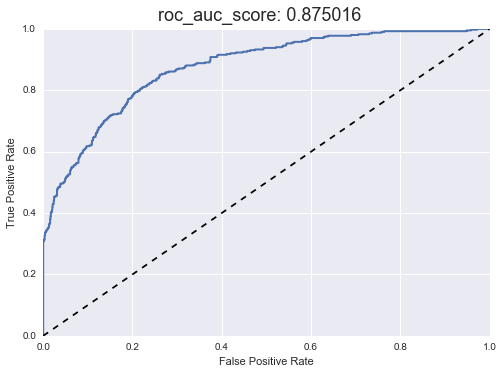

In [85]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=500,
algorithm="SAMME.R", learning_rate=0.05
)
ada_clf.fit(Xtr_r, raop_train_labels)


y_scores = ada_clf.decision_function(Xte_s)
fpr, tpr, thresholds = roc_curve(raop_test_labels, y_scores)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.figtext(.5, .92, 'roc_auc_score: %f'% roc_auc_score(raop_test_labels, y_scores), fontsize=18, ha='center')
plt.show();

## Visualization

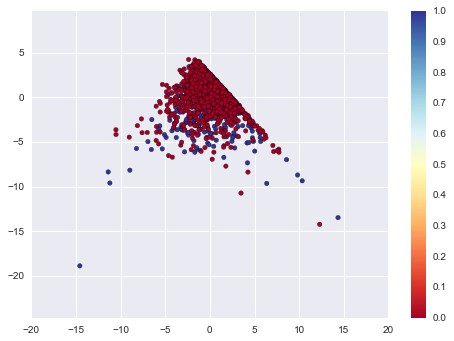

In [59]:
# Visualization using PCA for the generated data used with Unsupervised topic modeling
pca = PCA(n_components =2)
pca.fit(Xtr_s)
X_pca= pca.transform(Xte_s)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=raop_test_labels, cmap='RdYlBu')
plt.colorbar()
plt.axis('equal');

### Report

In [60]:
classifierReport('Machine Learning Classifier Report')
ensembling_1(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'Ensemble Report')
ensembling_2(Xtr_s, raop_train_labels, Xte_s, raop_test_labels, 'Ensemble Report')

Machine Learning Classifier Report
------------------------------------------------
AdaBoostClassifier accuracy:          85.530%
GradientBoostingClassifier accuracy:  85.469%
BaggingClassifier accuracy:           85.285%
--  n_estimators = 1000, max_samples = 150
RandomForestClassifier accuracy:      85.101%
--  n_estimators = 1000, max_leaf_nodes = 32, criterion = gini
LogisticRegression accuracy:          84.488%
SVC accuracy:                         84.120%
ExtraTreesClassifier accuracy:        82.833%
--  n_estimators = 1000, max_leaf_nodes = 40, criterion = "gini"
KNeighborsClassifier accuracy:        81.116%
--  n_neighbors = 2
LogisticRegression accuracy:          72.103%
--  Robust Scaling


Ensembling With Pre-Fitted Classifiers
---------------------------------------------
x_train_blend: (4040, 9)
x_test_blend: (1631, 9)

0 AdaBoostClassifier
1 GradientBoostingClassifier
2 BaggingClassifier
3 RandomForestClassifier
4 LogisticRegression
5 SVC
6 ExtraTreesClassifier
7 KNeighbo

In [61]:
classifierInfo_list = []

# Machine Learning with Stanford Narratives

In [62]:
np.random.seed(0)
def randomizeDataArrays(RAOP_updated_stanford):
    # create randomized arrays for test, dev and train
    X_sd = RAOP_updated_stanford.values
    global raop_test_sd, raop_train_sd
    global raop_test_labels_sd,raop_train_labels_sd
    global Xtr_s_sd, Xte_s_sd, Xtr_r_sd, Xte_r_sd
    
    raop_test_sd = X_sd[4040:]
    raop_train_sd = X_sd[:4040]
    
    raop_test_labels_sd = raop_test_sd[:,18]
    raop_train_labels_sd = raop_train_sd[:,18]

    raop_test_sd = np.delete(raop_test_sd , [18], axis=1)
    raop_train_sd = np.delete(raop_train_sd, [18], axis=1)
    
    # Scale data
    #Standard Scaler
    standard_scaler = preprocessing.StandardScaler()
    Xtr_s_sd = standard_scaler.fit_transform(raop_train_sd)
    Xte_s_sd = standard_scaler.transform(raop_test_sd)

    #Robust Scaler
    robust_scaler = preprocessing.RobustScaler()
    Xtr_r_sd = robust_scaler.fit_transform(raop_train_sd)
    Xte_r_sd = robust_scaler.transform(raop_test_sd)
    
# split out test and train from the dataframe
randomizeDataArrays(RAOP_updated_stanford)    
print "train data shape", raop_train_sd.shape
print "test data shape", raop_test_sd.shape

train data shape (4040, 36)
test data shape (1631, 36)


In [63]:
#Logistic Regression using Stat Models
# p-values are in column P>|t|
Xtr_s_sd_lr = sm.add_constant(Xtr_s_sd)
mod = sm.OLS(raop_train_labels_sd, Xtr_s_sd_lr )
res = mod.fit()
print(res.summary())
print(res.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     73.90
Date:                Sun, 11 Dec 2016   Prob (F-statistic):               0.00
Time:                        16:25:55   Log-Likelihood:                -1300.1
No. Observations:                4040   AIC:                             2674.
Df Residuals:                    4003   BIC:                             2908.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2460      0.005     46.631      0.0

In [64]:
# Logistic Regression using sklearn
raop_train_labels_sd = np.array(raop_train_labels_sd, dtype=int)
raop_test_labels_sd = np.array(raop_test_labels_sd, dtype=int)

logisticRegression(Xtr_s_sd, raop_train_labels_sd, Xte_s_sd, raop_test_labels_sd, 'Logistic Regression, Stanford Narratives', '')

Training set score: 85.371%
Test set score: 84.672%

Logistic Regression coefficients: [[ 2.52965011 -0.23407927  0.04221826  0.11855828  0.54267246 -2.52921505
   2.92016892  0.73710091 -1.98509719 -0.0257831   0.07859331 -0.09447684
   0.45547957 -0.00590815 -0.28847625 -0.30094331  1.07178008  0.14000808
  -0.23247465  0.41917937 -0.01968204 -0.01861847 -0.2194415   0.14813587
  -0.06544296 -0.04269695  0.01504741 -0.32157442  0.18299408  0.06809045
   0.41925015 -0.12042899  0.02504206  0.01969308  0.1125674  -0.03983799]]

Elapsed time (Logistic Regression, Stanford Narratives): 0:00.096
Total elapsed time: 38:16.332


In [65]:
# Logistic Regression with Robust Scaling
logisticRegression(Xtr_r_sd, raop_train_labels_sd, Xte_r_sd, raop_test_labels_sd, 'Logistic Regression, Stanford Narratives, Robust Scaling', 'Robust Scaling')

Training set score: 74.926%
Test set score: 74.617%

Logistic Regression coefficients: [[  3.49160624e-18  -2.86467815e-18  -7.32584252e-19  -5.49753603e-10
    3.31434598e-18  -4.32090399e-18   3.95426958e-18  -8.64443194e-17
    3.03792830e-18  -1.29389270e-17  -5.35301768e-18   3.64914008e-18
    1.18722020e-17  -1.53235903e-17  -1.11752396e-17   3.60428352e-19
    5.90877971e-18  -4.84357987e-18  -1.51051066e-17  -8.09752698e-18
   -2.16818525e-17  -1.12526982e-17  -1.34132981e-18  -2.39447706e-19
   -5.23909610e-18   1.03758920e-17   3.14592259e-18   2.14184384e-18
    1.51584516e-18   1.93031388e-18   3.17434896e-18  -1.10407915e-17
   -1.01967350e-17  -1.06768758e-17   2.64567371e-18  -1.14265545e-17]]

Elapsed time (Logistic Regression, Stanford Narratives, Robust Scaling): 0:00.009
Total elapsed time: 38:16.347


In [66]:
# Random Forest Classifier
y_pred_rf = randomForestClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'RandomForestClassifier, Stanford')

Accuracy: 84.97854%

Elapsed time (RandomForestClassifier, Stanford): 7:54.286
Total elapsed time: 46:10.644


In [67]:
# Bagging Classifier
baggingClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'BaggingClassifier, Stanford')

/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' i

Accuracy: 85.34641%

Elapsed time (BaggingClassifier, Stanford): 1:07.866
Total elapsed time: 47:18.633


In [68]:
# Extra Trees Classifier
extraTreesClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'RandomForestClassifier, Stanford')

Accuracy: 83.01655%

Elapsed time (RandomForestClassifier, Stanford): 6:48.404
Total elapsed time: 54:07.060


In [69]:
# Voting Classifier with LogisticRegression, RandomForestClassifier and SVM
votingClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'VotingClassifier, Stanford')

LogisticRegression, 84.611%
RandomForestClassifier, 84.365%
SVC, 84.181%
VotingClassifier, 84.611%

Elapsed time (VotingClassifier): 0:02.484
Total elapsed time: 54:09.584


In [70]:
# Ada Boost Classifier
adaBoostClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'AdaBoostClassifier, Stanford')

Accuracy: 85.59166%

Elapsed time (AdaBoostClassifier): 0:04.382
Total elapsed time: 54:13.973


In [71]:
# GradientBoostingClassifier
gradientBoostingClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'GradientBoostingClassifier')

Accuracy: 86.08216%

Elapsed time (GradientBoostingClassifier): 0:00.858
Total elapsed time: 54:14.849


In [72]:
# SVC Classifier
svcClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'SVC Classifier')

Accuracy: 84.18148%

Elapsed time (SVC Classifier): 0:02.689
Total elapsed time: 54:17.544


In [73]:
# KNeighborsClassifier
kNeighborsClassifier(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'KNeighborsClassifier')

Accuracy: 81.79031%

Elapsed time (KNeighborsClassifier): 0:02.805
Total elapsed time: 54:20.368


## ROC Curves

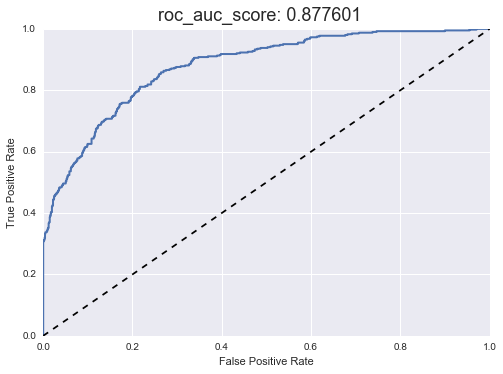

In [86]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=500,
algorithm="SAMME.R", learning_rate=0.05
)
ada_clf.fit(Xtr_r_sd, raop_train_labels)

y_scores_sd = ada_clf.decision_function(Xte_s_sd)
fpr_sd, tpr_sd, thresholds = roc_curve(raop_test_labels, y_scores_sd)
plt.plot(fpr_sd, tpr_sd, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.figtext(.5, .92, 'roc_auc_score: %f'% roc_auc_score(raop_test_labels, y_scores_sd), fontsize=18, ha='center')
plt.show();

# Visualization

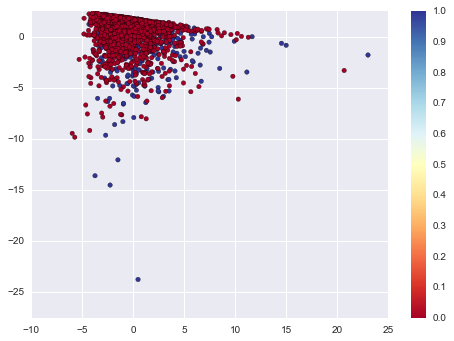

In [75]:
# Visualization using PCA for the generated data used 
pca = PCA(n_components =2)
pca.fit(Xtr_s_sd)
X_pca= pca.transform(Xte_s_sd)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=raop_test_labels, cmap='RdYlBu')
plt.colorbar()
plt.axis('equal');

## Classification Reports

In [76]:
classifierReport('Machine Learning Classifier Report, Stanford')
ensembling_1(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'Ensemble Report, Stanford')
ensembling_2(Xtr_s_sd, raop_train_labels, Xte_s_sd, raop_test_labels, 'Ensemble Report, Stanford')

Machine Learning Classifier Report, Stanford
------------------------------------------------
GradientBoostingClassifier accuracy:  86.082%
AdaBoostClassifier accuracy:          85.592%
BaggingClassifier accuracy:           85.346%
--  n_estimators = 500, max_samples = 250
RandomForestClassifier accuracy:      84.979%
--  n_estimators = 2000, max_leaf_nodes = 40, criterion = gini
LogisticRegression accuracy:          84.672%
SVC accuracy:                         84.181%
ExtraTreesClassifier accuracy:        83.017%
--  n_estimators = 2000, max_leaf_nodes = 40, criterion = "gini"
KNeighborsClassifier accuracy:        81.790%
--  n_neighbors = 2
LogisticRegression accuracy:          74.617%
--  Robust Scaling


Ensembling With Pre-Fitted Classifiers
---------------------------------------------
x_train_blend: (4040, 9)
x_test_blend: (1631, 9)

0 GradientBoostingClassifier
1 AdaBoostClassifier


/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' i

2 BaggingClassifier
3 RandomForestClassifier
4 LogisticRegression
5 SVC
6 ExtraTreesClassifier
7 KNeighborsClassifier
8 LogisticRegression

x_train_blend: (4040, 45)
x_test_blend: (1631, 45)

Ensemble Report, Stanford
------------------------------------------------
Accuracy: 84.304108%


Ensembling With Non-Fitted Classifiers
---------------------------------------------
x_train_blend: (4040, 5)
x_test_blend: (1631, 5)

0 RandomForestClassifier
1 RandomForestClassifier
2 ExtraTreesClassifier
3 ExtraTreesClassifier
4 GradientBoostingClassifier
(1631, 36) (1631, 5)

x_train_blend: (4040, 41)
x_test_blend: (1631, 41)

Ensemble Report, Stanford
------------------------------------------------
Accuracy: 85.591662%


## CNN

In [77]:
# immature CNN attempt, limited to 5 epochs
cnnProcess(Xtr_s, raop_train_labels, Xte_s, raop_test_labels)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '13065' (I am process '18355')


1) accuracy = 52.6058%
2) accuracy = 52.6058%
3) accuracy = 52.6058%
4) accuracy = 52.6058%
5) accuracy = 52.6058%
